# Books Recommender

The recommender consists of 2 steps:

1. Words embedding, and we used [AraVec](https://github.com/bakrianoo/aravec/blob/master/aravec-with-spacy.ipynb) for this task. 

2. Text similiraty measuring. We almost followed the toturial provided by [Dhilip Subramanian](https://medium.com/towards-artificial-intelligence/content-based-recommendation-system-using-word-embeddings-c1c15de1ef95) and adapted for our Arabic dataset. 

## 1. Setting up

In [47]:
import os
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
#pd.set_option('display.max_colwidth', -1) # To display whole data in columns

In [36]:
import gensim
import re
import spacy

In [56]:
'''from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random'''
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
#from gensim.models import Word2Vec
#from gensim.models.phrases import Phrases, Phraser
#from matplotlib import pyplot
#from gensim.models import KeyedVectors

In [2]:
descriptions = pd.read_csv('Data/Books_Data/Preprocessed_Dataset.csv')

In [3]:
descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13960 entries, 0 to 13959
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              13960 non-null  object 
 1   Author             13954 non-null  object 
 2   Description        13960 non-null  object 
 3   Genres             13193 non-null  object 
 4   URL                13960 non-null  object 
 5   Cover_URL          13956 non-null  object 
 6   word_count         13960 non-null  int64  
 7   char_count         13960 non-null  int64  
 8   avg_char_per_word  13960 non-null  float64
 9   stopwords          13960 non-null  int64  
 10  emoji_count        13960 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 1.2+ MB


In [34]:
# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

## 2. Initializing [AraVec](https://github.com/bakrianoo/aravec/blob/master/aravec-with-spacy.ipynb)

In [14]:
/Word2Vec/full_grams_cbow_100_wiki/f

/Users/haifaamohammad/MISK_DSI/Python/Arabic_Books_Recommender


In [19]:
model = gensim.models.Word2Vec.load("Word2Vec/full_grams_cbow_100_wiki.mdl")
print("We've",len(model.wv.index2word),"vocabularies")

We've 662109 vocabularies


In [20]:
# make a directory called "spacyModel"
%mkdir spacyModel

In [22]:
# export the word2vec fomart to the directory
model.wv.save_word2vec_format("./spacyModel/aravec.txt")

In [23]:
# using `gzip` to compress the .txt file
!gzip ./spacyModel/aravec.txt

In [25]:
!python -m spacy  init-model ar spacy.aravec.model --vectors-loc ./spacyModel/aravec.txt.gz

✔ Successfully created model
662109it [00:51, 12869.89it/s]
✔ Loaded vectors from spacyModel/aravec.txt.gz
✔ Sucessfully compiled vocab
662300 entries, 662109 vectors


## 3. Run AraVec 

In [30]:
# load AraVec Spacy model
nlp = spacy.load("./spacy.aravec.model/")

In [31]:
# Define the preprocessing Class
class Preprocessor:
    def __init__(self, tokenizer, **cfg):
        self.tokenizer = tokenizer

    def __call__(self, text):
        preprocessed = clean_str(text)
        return self.tokenizer(preprocessed)

In [32]:
# Apply the `Preprocessor` Class
nlp.tokenizer = Preprocessor(nlp.tokenizer)

## 4. Test the AraVec on Abjjad dataset

In [45]:
'''https://databatablog.wordpress.com/2019/09/21/emotion-classification-in-arabic-tweets-part-1/
def fetch_description_vec(description):
  for word in description:
    vec_words = []
    token = clean_str(word).replace(" ","_")
    if token in model.wv:
      vec_words += [model.wv[token]]
  desc_vec = np.mean(vec_words, axis=0)
  return desc_vec'''

In [48]:
#descriptions['desc_vec'] = descriptions['Description'].apply(lambda x: fetch_description_vec(x))
#descriptions = descriptions.dropna()
#descriptions['Description'].head()
#descriptions['desc_vec'].head()

0    عمر وقع يد فن تعامل ناس مءلف دايل كارنيجي راءع...
1    زخر تاريخ اسلامي رجل عظمة سطر حادث كبر حرف نور...
2    احتفي تاريخ سير محمدي افرد مجلد طوال ذكر احداث...
3    تحدث أسماء الله حسني عاش حرص مءلف مناسب متوسط ...
4    برع عباس محمود عقاد تناول شخصي امام ابي طالب م...
Name: Description, dtype: object

In [26]:
#splitting the description into words
corpus = []
for words in descriptions['Description']:
    corpus.append(words.split())

In [27]:
len(corpus)

13960

In [68]:
# Generate the average word2vec for the each book description

def vectors(x):
    
    # Creating a list for storing the vectors (description into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading the each book description 
    for line in descriptions['Description']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in model.wv.vocab:
                count += 1
                if avgword2vec is None:
                    avgword2vec = model[word]
                else:
                    avgword2vec = avgword2vec + model[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            word_embeddings.append(avgword2vec)

In [78]:
# Recommending the Top 5 similar books

def recommendations(title):
    
    # Calling the function vectors

    vectors(descriptions)
    
    # finding cosine similarity for the vectors

    cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

    # taking the title and book image link and store in new data frame called books
    books = descriptions[['Title', 'Cover_URL']]
    #Reverse mapping of the index
    indices = pd.Series(descriptions.index, index = descriptions['Title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]

    for index, row in recommend.iterrows():
        response = requests.get(row['Cover_URL'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        #plt.title(row['Title'])

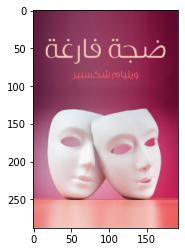

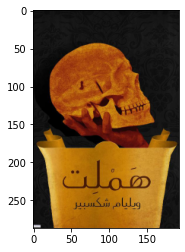

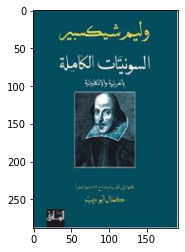

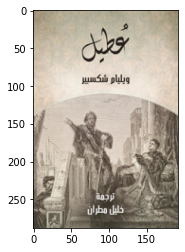

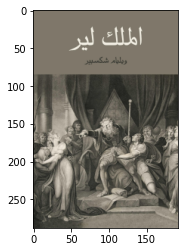

In [80]:
# Test on Crime and Punishment
recommendations('الجريمة والعقاب #1')

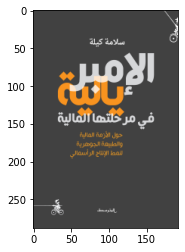

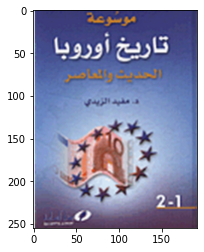

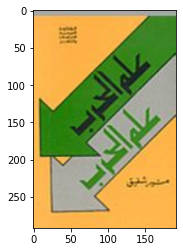

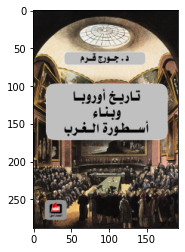

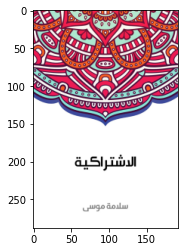

In [85]:
recommendations('قصة الفلسفة')

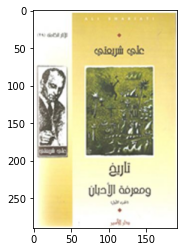

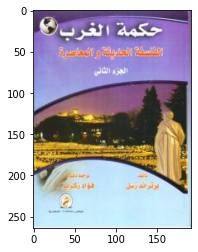

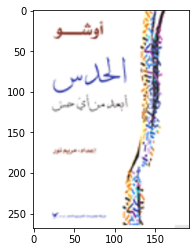

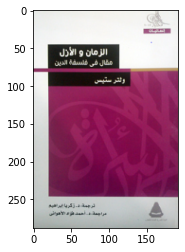

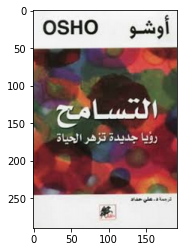

In [86]:
recommendations('الإسلام بين الشرق والغرب')